In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ciplab/real-and-fake-face-detection")

print("Path to dataset files:", path)



100%|██████████| 431M/431M [00:02<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1


In [9]:
import os

# List everything inside the dataset directory
for root, dirs, files in os.walk(path):
    print("📂 Folder:", root)
    for d in dirs:
        print("   ┣━ 📁", d)
    for f in files[:5]:  # Show only first 5 files
        print("   ┣━ 📄", f)
    print()




📂 Folder: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1
   ┣━ 📁 real_and_fake_face_detection
   ┣━ 📁 real_and_fake_face

📂 Folder: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face_detection
   ┣━ 📁 real_and_fake_face

📂 Folder: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face_detection/real_and_fake_face
   ┣━ 📁 training_fake
   ┣━ 📁 training_real

📂 Folder: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face_detection/real_and_fake_face/training_fake
   ┣━ 📄 easy_236_1100.jpg
   ┣━ 📄 hard_136_1101.jpg
   ┣━ 📄 mid_129_0101.jpg
   ┣━ 📄 mid_203_1111.jpg
   ┣━ 📄 easy_78_1111.jpg

📂 Folder: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face_detection/real_and_fake_face/training_real
   ┣━ 📄 real_00789.jpg
   ┣━ 📄 real_00577.jpg
   ┣━ 📄 real_00019.jpg
   ┣━ 📄 real_00504.

In [11]:
real_path = "/root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face/training_real"
fake_path = "/root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face/training_fake"


In [12]:

import os
import cv2
import numpy as np

def load_images_from_folder(folder, label, image_size=(128, 128)):
    data = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            data.append([img, label])
    return data

# Use final paths
real_images = load_images_from_folder(real_path, 0)  # real = 0
fake_images = load_images_from_folder(fake_path, 1)  # fake = 1

# Combine and shuffle
data = real_images + fake_images
np.random.shuffle(data)

# Split X (images) and y (labels)
X = np.array([item[0] for item in data])
y = np.array([item[1] for item in data])

# Normalize image data
X = X / 255.0


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 855ms/step - accuracy: 0.5287 - loss: 0.9696 - val_accuracy: 0.5330 - val_loss: 0.6902
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 77s 764ms/step - accuracy: 0.5033 - loss: 0.6897 - val_accuracy: 0.5599 - val_loss: 0.6770
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 762ms/step - accuracy: 0.6152 - loss: 0.6512 - val_accuracy: 0.5966 - val_loss: 0.6691
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 771ms/step - accuracy: 0.6939 - loss: 0.5994 - val_accuracy: 0.5648 - val_loss: 0.6796
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - accuracy: 0.7138 - loss: 0.5764 - val_accuracy: 0.5868 - val_loss: 0.7662


In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.5976 - loss: 0.7629
✅ Test Accuracy: 58.68%


In [16]:
print("Real images:", len(real_images))
print("Fake images:", len(fake_images))


Real images: 1081
Fake images: 960


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)


In [18]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=10,
          validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 933ms/step - accuracy: 0.6418 - loss: 0.6410 - val_accuracy: 0.5966 - val_loss: 0.7127
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 871ms/step - accuracy: 0.6565 - loss: 0.6203 - val_accuracy: 0.5721 - val_loss: 0.6811
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 921ms/step - accuracy: 0.6443 - loss: 0.6256 - val_accuracy: 0.5746 - val_loss: 0.6952
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 869ms/step - accuracy: 0.6464 - loss: 0.6183 - val_accuracy: 0.5917 - val_loss: 0.6950
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 860ms/step - accuracy: 0.6429 - loss: 0.6311 - val_accuracy: 0.5892 - val_loss: 0.6846
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 0.6551 - loss: 0.6265 - val_accuracy: 0.5575 - val_loss: 0.7247
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 889ms/step - accuracy: 0.6736 - loss: 0.6075 - val_accuracy: 0.6112 - val_loss: 0.6943
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 868ms/step - accuracy: 0.6928 - loss: 0.5895 - val_accu

In [22]:
from tensorflow.keras import Input, layers, models

model = models.Sequential([
    Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary output
])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5052 - loss: 0.6929 - val_accuracy: 0.5330 - val_loss: 0.6920
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5362 - loss: 0.6920 - val_accuracy: 0.5330 - val_loss: 0.6913
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5352 - loss: 0.6918 - val_accuracy: 0.5330 - val_loss: 0.6913
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5217 - loss: 0.6925 - val_accuracy: 0.5330 - val_loss: 0.6911
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5124 - loss: 0.6935 - val_accuracy: 0.5330 - val_loss: 0.6910
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5365 - loss: 0.6917 - val_accuracy: 0.5330 - val_loss: 0.6916
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5376 - loss: 0.6911 - val_accuracy: 0.5330 - val_loss: 0.6914
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5278 - loss: 0.6917 - val_accuracy: 0.5330 - val_loss:

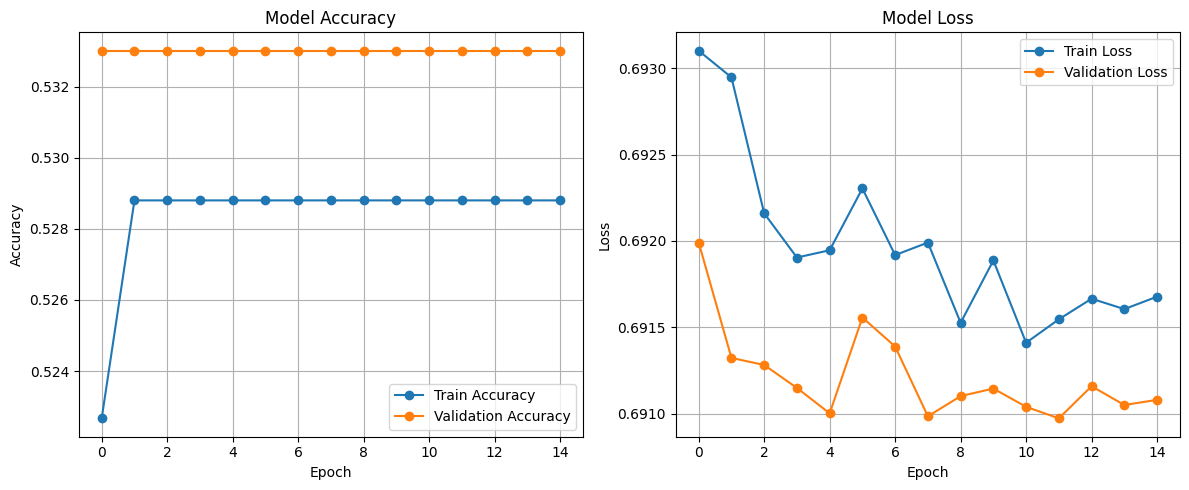

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# (Optional) If you haven't split yet:
# X = np.array(all_images)      # All images
# y = np.array(all_labels)      # Corresponding labels (0 = real, 1 = fake)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Normalize the images (IMPORTANT!)
X_train = X_train / 255.0
X_test = X_test / 255.0

# ✅ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# ✅ Define the CNN Model
model = models.Sequential([
    Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# ✅ Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ✅ Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_test, y_test)
)

# ✅ Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Saving b.webp to b.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


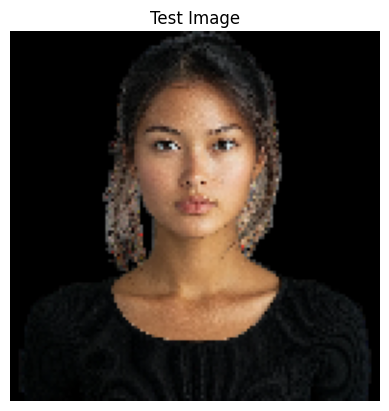

🧠 Prediction: REAL Face 😊 (54.43% confidence)


In [27]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Upload image
uploaded = files.upload()

for filename in uploaded:
    # Step 2: Load and preprocess image
    img = cv2.imread(filename)
    img = cv2.resize(img, (128, 128))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = img_rgb / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict
    prediction = model.predict(img_array)[0][0]

    # Step 4: Display image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Test Image")
    plt.show()

    # Step 5: Print prediction + confidence
    confidence = prediction * 100 if prediction >= 0.5 else (1 - prediction) * 100
    label = "FAKE Face 🤖" if prediction >= 0.5 else "REAL Face 😊"
    print(f"🧠 Prediction: {label} ({confidence:.2f}% confidence)")


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step


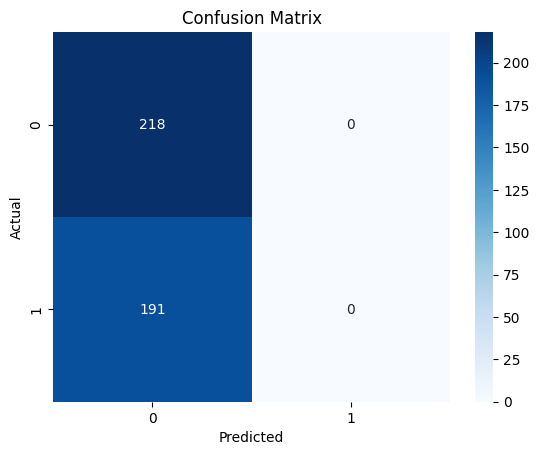

              precision    recall  f1-score   support

        Real       0.53      1.00      0.70       218
        Fake       0.00      0.00      0.00       191

    accuracy                           0.53       409
   macro avg       0.27      0.50      0.35       409
weighted avg       0.28      0.53      0.37       409



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
